# Part 5 – Market Basket Analysis & Product Recommendations

In this notebook, I have extend the Instacart Market Basket Analysis project by applying **association rule mining**, **product embeddings**, and **recommendation modeling** to uncover product affinities and build personalized suggestions.


## Objectives
- Identify frequently purchased products and co-occurring product pairs.
- Use **Apriori Algorithm** and **Association Rules** to uncover strong relationships between items.
- Train a **Word2Vec embedding model** to represent products in a semantic vector space.
- Visualize product embeddings in **2D space using PCA**.
- Cluster products into groups using **KMeans**.
- Build **recommendation functions**:
  - Product-to-product recommendations
  - Basket-based recommendations
  - User-personalized recommendations

## Step 1: Data Preparation
- Transactions (`order_id` → list of `product_name`) were grouped into **baskets**.
- Data transformed into one-hot encoded basket matrix using **TransactionEncoder**.

## Step 2: Frequent Itemsets (Apriori)
- Applied **Apriori algorithm** (`min_support = 0.01`) to extract frequent itemsets.
- Most common single-item purchases:
  - **Banana** (support ≈ 14.7%)
  - **Bag of Organic Bananas**
  - **Organic Strawberries**
  - **Organic Baby Spinach**
  - **Organic Hass Avocado**
- Demonstrates strong dominance of fresh produce in Instacart purchases.

**Frequent itemsets were mined at scale, though only the top items are reported here for readability.**

## Step 3: Association Rules
- Derived **rules** using metrics: *support, confidence, lift*.
- Example high-lift associations:
  - `Organic Raspberries → Organic Strawberries` (lift ≈ 3.0)
  - `Banana ↔ Organic Fuji Apple` (lift ≈ 2.6)
  - `Bag of Organic Bananas ↔ Organic Hass Avocado` (lift ≈ 2.5)
- Insight: **fruits & fresh produce exhibit strong co-purchase patterns**.

**Generated association rules on the full frequent itemsets.**
**Rules were computed at scale; notebook highlights only the strongest examples (by lift).**

## Step 4: Product Embeddings (Word2Vec)
- Trained a **Word2Vec model** on baskets (`vector_size=50`, `window=5`, `sg=1`).
- Each product is represented as a dense vector capturing **semantic similarity**.
- At this stage, we only demonstrated the approach with a few example queries rather than a full exploration of all products.
- Example results:
  - *Organic Avocado* → {Cucumber Kirby, Large Lemon, Honeycrisp Apple}
  - *Bag of Organic Bananas* → {Organic Strawberries, Organic Blueberries, Organic Spinach}
  - *Organic Strawberries* → {Bag of Organic Bananas, Organic Blueberries, Organic Baby Carrots}

**These examples show that embeddings can successfully capture meaningful product relationships. Full-scale similarity search across the catalog can be extended in future steps.**


## Step 5: Embedding Visualization
- Reduced embeddings to **2D with PCA**.
- Plotted top 100 most popular products.
- Observed clusters of:
  - Dairy products (milk, cheese, yogurt)
  - Fresh produce (bananas, avocados, berries)
  - Packaged goods (cola, cereal, peanut butter)

## Step 6: Product Clustering
- Applied **KMeans (k=10)** to product vectors.
- Sample clusters:
  - **Cluster 0:** Processed/packaged foods (cola, cereal, peanut butter, English muffins)
  - **Cluster 1:** Beverages & household essentials (sparkling water, skim milk, chicken breast, tissues, eggs)
  - **Cluster 2:** Fresh produce (banana, avocado, strawberries, limes, apples)

## Step 7: Recommendation System
### 1. **Product-to-Product**
- `recommend_products("Organic Baby Spinach")`
  → Organic Almond Milk, Organic Spring Mix, Organic Baby Carrots

### 2. **Basket-Based**
- Example basket: {Avocado, Baby Spinach, Bananas}
  → Recommended: {Organic Strawberries, Organic Spring Mix, Almond Milk}

### 3. **User-Based**
- Past purchases aggregated into **user basket profile**.
- Generated recommendations aligned to historical behavior.
- Example output for `user_id=12345`:
  - Rising Crust Pizza, Chicken Breast Strips, Apple Juice, etc.
 
**- This step 7 is also a demonstration step:
  - Functions were implemented and tested. 
  - Only a few baskets and one user were used as examples, not the full dataset of users.**

## Key Insights
- **Fresh produce** drives frequent purchases and strong product affinities.
- **Association rules** highlight common bundles (e.g., berries + bananas, avocado + bananas).
- **Word2Vec embeddings** capture nuanced similarity beyond co-occurrence (e.g., citrus fruits grouped together).
- **Clustering + embeddings** provide interpretable product groups.
- **Recommendation functions** demonstrate scalability from single product → basket → user-level personalization.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.stats import entropy
import sys
#!{sys.executable} -m pip install shap

In [3]:
prior_data = pd.read_pickle('prior_data.pkl')

1. Apriori/Product Pair Mining

In [6]:
import numpy as np

def reduce_memory(df):
    """
    Reduces memory usage of a DataFrame by downcasting numeric types.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
    
    Returns:
        pd.DataFrame: Optimized DataFrame.
    """
    start_mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is: {:.2f} MB".format(start_mem_usg))

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in ["int64", "int32", "int16"]:
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)

        elif col_type in ["float64", "float32"]:
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)

    mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(mem_usg))
    print("Decreased by {:.1f}%".format(100 * (start_mem_usg - mem_usg) / start_mem_usg))

    return df
prior_data = reduce_memory(prior_data)

Memory usage of dataframe is: 3711.83 MB
Memory usage after optimization is: 1701.26 MB
Decreased by 54.2%


In [8]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

In [12]:
baskets = prior_data.groupby('order_id')['product_name'].apply(list).tolist()

In [14]:
te = TransactionEncoder()
te_matrix = te.fit(baskets).transform(baskets, sparse=True)
df_te = pd.DataFrame.sparse.from_spmatrix(te_matrix, columns=te.columns_)

/var/folders/d9/7q11w0fj4h37hzlh3m8w5rx80000gn/T/ipykernel_87028/292143796.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_te = pd.DataFrame.sparse.from_spmatrix(te_matrix, columns=te.columns_)


In [16]:
frequent_itemsets = apriori(df_te, min_support=0.01, use_colnames=True)

In [18]:
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False).reset_index(drop=True)
print(frequent_itemsets.head(20))

     support                    itemsets
0   0.146993                    (Banana)
1   0.118030    (Bag of Organic Bananas)
2   0.082331      (Organic Strawberries)
3   0.075251      (Organic Baby Spinach)
4   0.066436      (Organic Hass Avocado)
5   0.054999           (Organic Avocado)
6   0.047485               (Large Lemon)
7   0.044466              (Strawberries)
8   0.043743                     (Limes)
9   0.042896        (Organic Whole Milk)
10  0.042632       (Organic Raspberries)
11  0.035282      (Organic Yellow Onion)
12  0.034147            (Organic Garlic)
13  0.032606          (Organic Zucchini)
14  0.031124       (Organic Blueberries)
15  0.030270            (Cucumber Kirby)
16  0.027880        (Organic Fuji Apple)
17  0.027294             (Organic Lemon)
18  0.026446  (Apple Honeycrisp Organic)
19  0.026208    (Organic Grape Tomatoes)


In [20]:
from mlxtend.frequent_patterns import association_rules

# Focusing on 2-item+ combinations
frequent_itemsets = apriori(df_te, min_support=0.01, use_colnames=True, max_len=2)

# Generating association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

# Show top rules
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10)


,antecedents,consequents,support,confidence,lift
26,(Organic Raspberries),(Organic Strawberries),0.010533,0.247072,3.000973
27,(Organic Strawberries),(Organic Raspberries),0.010533,0.127938,3.000973
14,(Organic Fuji Apple),(Banana),0.010558,0.378693,2.576259
15,(Banana),(Organic Fuji Apple),0.010558,0.071827,2.576259
5,(Organic Raspberries),(Bag of Organic Bananas),0.012599,0.295519,2.503775
4,(Bag of Organic Bananas),(Organic Raspberries),0.012599,0.106741,2.503775
2,(Bag of Organic Bananas),(Organic Hass Avocado),0.019391,0.164293,2.472945
3,(Organic Hass Avocado),(Bag of Organic Bananas),0.019391,0.291880,2.472945
24,(Organic Hass Avocado),(Organic Strawberries),0.012689,0.190997,2.319880
25,(Organic Strawberries),(Organic Hass Avocado),0.012689,0.154124,2.319880


Word2Vec model

In [23]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np

# Building baskets (each order as a list of product names)
baskets = prior_data.groupby('order_id')['product_name'].apply(list).tolist()

# Training Word2Vec model
w2v_model = Word2Vec(
    sentences=baskets,
    vector_size=50,     # embedding dimensions
    window=5,           # context window
    min_count=10,       # ignoring rare products
    workers=4,
    sg=1                # using skip-gram (better for finding similar items)
)

# Exploring similar products
print("Similar to Organic Avocado:")
print(w2v_model.wv.most_similar("Organic Avocado", topn=5))

# Exporting product vectors to CSV
product_list = w2v_model.wv.index_to_key
vectors = [w2v_model.wv[product] for product in product_list]
vectors_df = pd.DataFrame(vectors, index=product_list)
vectors_df.to_csv("product_vectors.csv")
print("Saved product vectors to product_vectors.csv")

Similar to Organic Avocado:
[('Cucumber Kirby', 0.830557644367218), ('Large Lemon', 0.7958562970161438), ('Honeycrisp Apple', 0.7547309994697571), ('Organic Baby Arugula', 0.7531910538673401), ('Broccoli Crown', 0.7516440749168396)]
Saved product vectors to product_vectors.csv


In [25]:
# Find products similar to a given product and display

# Choose any product to explore (must exist in vocab)
target_product = "Organic Avocado"

# Get top 10 most similar products
similar_items = w2v_model.wv.most_similar(target_product, topn=10)

# Convert to DataFrame
similar_df = pd.DataFrame(similar_items, columns=["Similar Product", "Similarity Score"])

# Show result
print(f"Products similar to: {target_product}")
similar_df

Products similar to: Organic Avocado


,Similar Product,Similarity Score
0,Cucumber Kirby,0.830558
1,Large Lemon,0.795856
2,Honeycrisp Apple,0.754731
3,Organic Baby Arugula,0.753191
4,Broccoli Crown,0.751644
5,"Cocktail Mixer, Mojito",0.746360
6,Michigan Organic Kale,0.745576
7,Organic Romaine,0.731005
8,Banana,0.725926
9,Organic Cherry Tomatoes,0.725745


In [27]:
# (multi-product): Find similar products for multiple inputs

# List of target products
target_products = ["Organic Avocado", "Bag of Organic Bananas", "Organic Strawberries"]

# Creating an empty list to store all results
all_similar = []

# Looping through each product and get similar ones
for product in target_products:
    try:
        similar_items = w2v_model.wv.most_similar(product, topn=5)
        for sim_product, score in similar_items:
            all_similar.append({
                "Input Product": product,
                "Similar Product": sim_product,
                "Similarity Score": round(score, 4)
            })
    except KeyError:
        print(f" '{product}' not found in model vocabulary.")

# Convert to DataFrame
multi_sim_df = pd.DataFrame(all_similar)

# Show results
multi_sim_df


,Input Product,Similar Product,Similarity Score
0,Organic Avocado,Cucumber Kirby,0.8306
1,Organic Avocado,Large Lemon,0.7959
2,Organic Avocado,Honeycrisp Apple,0.7547
3,Organic Avocado,Organic Baby Arugula,0.7532
4,Organic Avocado,Broccoli Crown,0.7516
5,Bag of Organic Bananas,Organic Strawberries,0.8764
6,Bag of Organic Bananas,Organic Half & Half,0.8281
7,Bag of Organic Bananas,Organic Baby Spinach,0.7849
8,Bag of Organic Bananas,Organic Blueberries,0.7842
9,Bag of Organic Bananas,Spring Water,0.7832


Visualize Embeddings with PCA (2D Plot)

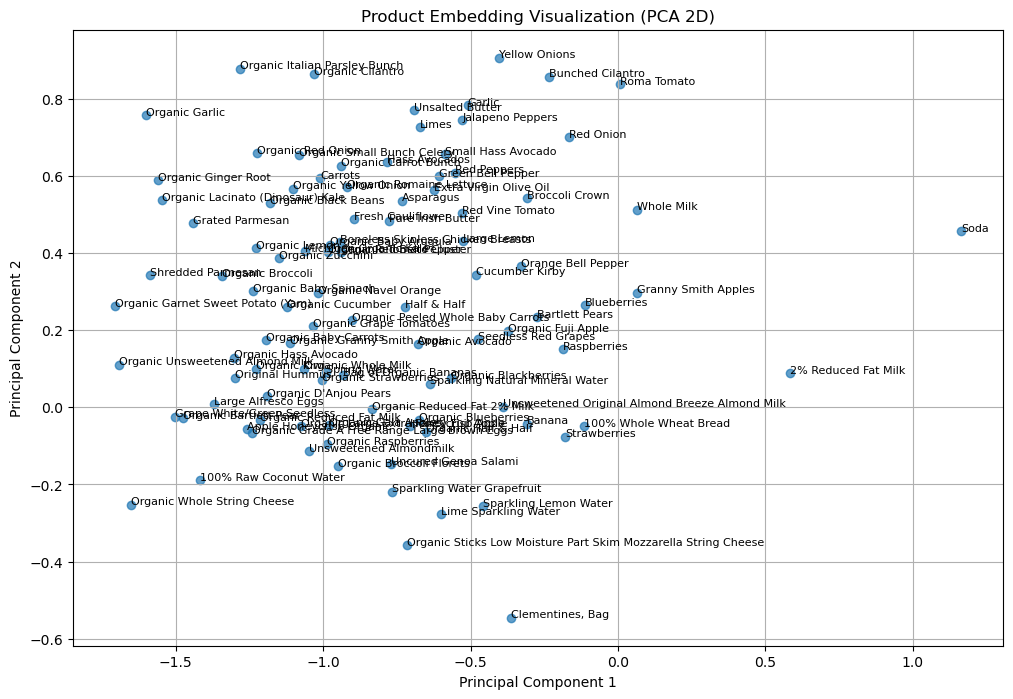

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors_df)

# Build a DataFrame for plotting
viz_df = pd.DataFrame(vectors_2d, columns=['PC1', 'PC2'], index=vectors_df.index)

# Plot a sample of 100 popular products for readability
sample_products = prior_data['product_name'].value_counts().head(100).index
sample_df = viz_df[viz_df.index.isin(sample_products)]

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(sample_df['PC1'], sample_df['PC2'], alpha=0.7)

# Annotate points
for product, (x, y) in sample_df.iterrows():
    plt.text(x, y, product, fontsize=8)

plt.title('Product Embedding Visualization (PCA 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


Product Clustering Using Vectors (KMeans) - Group similar products using KMeans

In [33]:
from sklearn.cluster import KMeans

# Choose number of clusters 
kmeans = KMeans(n_clusters=10, random_state=42)
vectors_df['cluster'] = kmeans.fit_predict(vectors_df)

# View sample of products from a cluster
for i in range(3):
    print(f"\n Cluster {i}")
    print(vectors_df[vectors_df['cluster'] == i].head(10).index.tolist())



 Cluster 0
['2% Reduced Fat Milk', 'Creamy Peanut Butter', 'Fridge Pack Cola', 'Original Nooks & Crannies English Muffins', 'Cereal', 'Cola', 'Purified Water', 'Coke Classic', 'Mixed Fruit Fruit Snacks', 'French Vanilla Creamer']

 Cluster 1
['Grapefruit Sparkling Water', 'Honeycrisp Apples', 'Lemon Sparkling Water', 'Fat Free Skim Milk', '1% Low Fat Milk', 'Passionfruit Sparkling Water', 'Boneless Skinless Chicken Breast Fillets', 'Ultra Soft Facial Tissues', 'Cage Free Grade A Large Brown Eggs', 'White Giant Paper Towel Rolls']

 Cluster 2
['Banana', 'Organic Avocado', 'Large Lemon', 'Strawberries', 'Limes', 'Organic Blueberries', 'Cucumber Kirby', 'Organic Fuji Apple', 'Organic Grape Tomatoes', 'Seedless Red Grapes']


Build a Simple Recommendation System Using Similarity (Word2Vec model)

In [36]:
def recommend_products(product_name, topn=5):
    try:
        return w2v_model.wv.most_similar(product_name, topn=topn)
    except KeyError:
        return f" '{product_name}' not found in model vocabulary."

# Example
recommend_products("Organic Baby Spinach")


[('Organic Unsweetened Almond Milk', 0.9131690859794617),
 ('Organic Spring Mix', 0.8991538882255554),
 ('Organic Baby Carrots', 0.8852425217628479),
 ('Organic Egg Whites', 0.8788308501243591),
 ('Organic Broccoli', 0.8706855177879333)]

Recommend Based on Basket of Products

In [39]:
def recommend_from_basket(basket_products, topn=10):
    """Recommend products based on multiple items in the basket."""
    valid_vectors = []
    
    for prod in basket_products:
        if prod in w2v_model.wv:
            valid_vectors.append(w2v_model.wv[prod])
        else:
            print(f" '{prod}' not in vocabulary.")
    
    if not valid_vectors:
        return " No valid products in vocabulary."

    # Compute the average vector of the basket
    basket_vector = np.mean(valid_vectors, axis=0)
    
    # Get similar items to the average vector
    similar_items = w2v_model.wv.similar_by_vector(basket_vector, topn=topn)

    # Remove products already in the basket
    recommendations = [(item, score) for item, score in similar_items if item not in basket_products]
    
    return recommendations


In [41]:
basket = ["Organic Avocado", "Organic Baby Spinach", "Bag of Organic Bananas"]
recommend_from_basket(basket, topn=5)


[('Organic Strawberries', 0.8907411098480225),
 ('Organic Spring Mix', 0.8332717418670654),
 ('Organic Unsweetened Almond Milk', 0.832373857498169)]

Incorporate User Behavior for Personalized Recs

In [45]:
def get_user_basket(user_id):
    """Returns a list of past products purchased by the user."""
    return prior_data[prior_data['user_id'] == user_id]['product_name'].unique().tolist()

def recommend_for_user(user_id, topn=10):
    """Recommends products for a given user based on past purchase behavior."""
    user_basket = get_user_basket(user_id)
    return recommend_from_basket(user_basket, topn=topn)


In [47]:
recommend_for_user(user_id=12345, topn=10)

[('Naturally Rising Crust Sausage & Pepperoni Pizza', 0.965035080909729),
 ('Adult Complete Nutrition Dry Food for Dogs Bonus', 0.9628505706787109),
 ('Big Cup Noodles Homestyle Shrimp Flavor', 0.9541981220245361),
 ('Whole Grain Chicken Breast Strips', 0.9484112858772278),
 ('Spicy Italian Sausage Rising Crust Pizza', 0.9471428394317627),
 ('Light Apple Juice Cocktail', 0.9466046094894409),
 ('Gluten Free Breast Strips', 0.9456138610839844),
 ('Envelopes, Security, Strip & Seal, No. 6-3/4', 0.9455932974815369),
 ('Shoestring French Fried Potatoes', 0.944669246673584),
 ('SmartBlend Classic Ground Turkey & Barley Entree Adult Dog Food',
  0.9437969923019409)]